In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler
from torchvision.models import resnet50
from torch.utils.data import random_split

In [2]:
#Use the ResNet18 on Cifar-10
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
import os

#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#set hyperparameter
EPOCH = 10
pre_epoch = 0
BATCH_SIZE = 32
LR = 0.001


cuda


#### Transformer

In [3]:
# 训练数据的 transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 测试数据的 transforms
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [4]:
data_path = "./training/"

dataset = torchvision.datasets.ImageFolder(data_path)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [5]:
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_test

In [6]:

trainloader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

testloader = torch.utils.data.DataLoader(val_dataset,
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

import os
classes = list(os.listdir(data_path))[1:] 
classes

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spyder',
 'squirrel']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


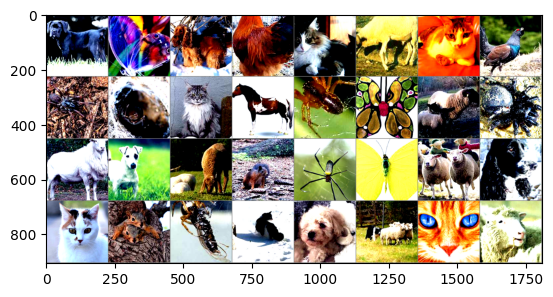

dog   butterfly dog   chicken cat   sheep cat   chicken spyder spyder cat   horse spyder butterfly sheep spyder sheep dog   sheep squirrel spyder butterfly sheep dog   cat   squirrel spyder cat   dog   sheep cat   sheep


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))

# print(images.shape)

In [8]:
#define model
net = resnet50()

net.fc = nn.Linear(in_features=2048, out_features=10)
net = net.to(device)
print(net)

#define loss funtion & optimizer
optimizer = optim.RMSprop(net.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
from tqdm import tqdm

In [10]:
scaler = GradScaler()

#train
for epoch in range(pre_epoch, EPOCH):
    print(f"\nEpoch: {epoch + 1}")
    net.train()
    sum_loss, correct, total= 0.0, 0.0, 0.0
    
    
    with tqdm(trainloader , unit="batch" ,desc='Training') as t_epoch:
        for data in t_epoch:
            torch.cuda.empty_cache()
            #prepare dataset
            length = len(trainloader)
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            #forward & backward
            with torch.cuda.amp.autocast():
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            
            #print ac & loss in each batch
            sum_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).cpu().sum()
    
    train_acc = 100.0 * correct / total
    
    #get the ac with testdataset in each epoch
    print('Waiting Test...')
    with torch.no_grad():
        correct , total = 0, 0
        
        with tqdm(testloader , unit="batch" ,desc='Testing') as t_epoch_test:
            for data in t_epoch_test:
                torch.cuda.empty_cache()
                net.eval()
                
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()
        
        print(f'[epoch:{epoch+1}] Loss: {loss:.3f} | Train Acc: {train_acc:.3f} | Test Acc :  {(100 * correct / total):.3f}')

print(f"Train has finished, total epoch is {EPOCH}")


Epoch: 1


Training: 100%|██████████| 629/629 [02:20<00:00,  4.47batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:21<00:00,  7.50batch/s]


[epoch:1] Loss: 1.888 | Train Acc: 27.463 | Test Acc :  37.987

Epoch: 2


Training: 100%|██████████| 629/629 [02:20<00:00,  4.49batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:21<00:00,  7.47batch/s]


[epoch:2] Loss: 1.739 | Train Acc: 41.316 | Test Acc :  45.286

Epoch: 3


Training: 100%|██████████| 629/629 [02:18<00:00,  4.55batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:20<00:00,  7.58batch/s]


[epoch:3] Loss: 0.752 | Train Acc: 52.872 | Test Acc :  52.148

Epoch: 4


Training: 100%|██████████| 629/629 [02:18<00:00,  4.55batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:20<00:00,  7.63batch/s]


[epoch:4] Loss: 0.843 | Train Acc: 59.674 | Test Acc :  60.800

Epoch: 5


Training: 100%|██████████| 629/629 [02:17<00:00,  4.58batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:20<00:00,  7.79batch/s]


[epoch:5] Loss: 0.595 | Train Acc: 64.219 | Test Acc :  63.166

Epoch: 6


Training: 100%|██████████| 629/629 [02:15<00:00,  4.65batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:19<00:00,  8.24batch/s]


[epoch:6] Loss: 0.477 | Train Acc: 67.973 | Test Acc :  66.806

Epoch: 7


Training: 100%|██████████| 629/629 [02:16<00:00,  4.59batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:20<00:00,  7.67batch/s]


[epoch:7] Loss: 0.562 | Train Acc: 71.453 | Test Acc :  68.656

Epoch: 8


Training: 100%|██████████| 629/629 [02:15<00:00,  4.65batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:19<00:00,  8.18batch/s]


[epoch:8] Loss: 1.047 | Train Acc: 74.114 | Test Acc :  69.292

Epoch: 9


Training: 100%|██████████| 629/629 [02:13<00:00,  4.72batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:19<00:00,  8.12batch/s]


[epoch:9] Loss: 0.679 | Train Acc: 77.082 | Test Acc :  67.999

Epoch: 10


Training: 100%|██████████| 629/629 [02:12<00:00,  4.74batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:19<00:00,  8.27batch/s]


[epoch:10] Loss: 0.685 | Train Acc: 79.747 | Test Acc :  74.483

Epoch: 11


Training: 100%|██████████| 629/629 [02:12<00:00,  4.76batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:19<00:00,  8.31batch/s]


[epoch:11] Loss: 0.398 | Train Acc: 81.746 | Test Acc :  73.846

Epoch: 12


Training: 100%|██████████| 629/629 [02:14<00:00,  4.69batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:19<00:00,  8.23batch/s]


[epoch:12] Loss: 0.657 | Train Acc: 84.362 | Test Acc :  71.818

Epoch: 13


Training: 100%|██████████| 629/629 [02:12<00:00,  4.75batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:19<00:00,  8.16batch/s]


[epoch:13] Loss: 0.843 | Train Acc: 86.013 | Test Acc :  69.033

Epoch: 14


Training: 100%|██████████| 629/629 [02:19<00:00,  4.51batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:20<00:00,  7.56batch/s]


[epoch:14] Loss: 0.463 | Train Acc: 88.285 | Test Acc :  70.267

Epoch: 15


Training: 100%|██████████| 629/629 [02:19<00:00,  4.51batch/s]


Waiting Test...


Testing: 100%|██████████| 158/158 [00:20<00:00,  7.83batch/s]

[epoch:15] Loss: 0.104 | Train Acc: 89.981 | Test Acc :  77.625
Train has finished, total epoch is 15


In [11]:
PATH = './HW4_ResNet50_net.pth'
torch.save(net.state_dict(), PATH)

In [12]:
MODEL_PATH = './HW4_ResNet50_net.model'
torch.save(net, MODEL_PATH)

In [13]:
torch.cuda.empty_cache()